## Метод k ближайших соседей: практика - Титаник

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.datasets import make_checkerboard, make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error as MSE

In [3]:
# Здесь не использовалась
def get_grid(data):
    """
    Вспомогательная функция для построения сетки.
    """
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

Датасет с данными о пассажирах "Титаника". Каждая запись соответствует одному пассажиру корабля, поле "Survived" является для нас целевой переменной (соответственно, 0 для утонувших и 1 для спасшихся). Предлагается обучить модель kNN для ей предсказания и подобрать оптимальные гиперпараметры с помощью перебора по сетке GridSearchCV.

Параметры, которые надо оптимизировать:
* n_neighbors
* metric
* p\*
* weights

In [5]:
data = pd.read_csv('titanic.csv')#, index_col='PassengerId')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].copy()
X.Sex = X.Sex.map({'male' : 0, 'female' : 1})
X.Age.fillna(value = X['Age'].mean(), inplace=True)
y = data['Survived']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
n_neighbors = range(1,102, 5)
metric = ['minkowski']
p = range(1,5)
weights = ['uniform', 'distance']

In [11]:
knn = KNeighborsClassifier()

In [12]:
#train_scores, y_train = validation_curve(knn, X_train, y_train, 'p', p, verbose=1)

In [13]:
def make_validation_curve(classifier, X, y, param_list, param_name):
    train_scores, test_scores = validation_curve(classifier, X, y, param_name=param_name, param_range=param_list,
        cv=10, scoring="accuracy", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plot_validation_curve(param_list, param_name, train_scores_mean,
                                                  train_scores_std,
                                                  test_scores_mean,
                                                  test_scores_std)

In [14]:
def plot_validation_curve(param_list, param_name, cv_train_mean, cv_train_std, cv_test_mean, cv_test_std, logscale=False):
    """
    Вспомогательная функция для построения кривых качества на валидации/тесте в зависимости от значений гиперпараметра.
    param_list: список из значений параметра
    param_name: имя для параметра (для отображения на графике)
    cv_train_mean: список из значений метрики качества на обучающей подвыборке для каждого значения параметра
    cv_train_std: СКО для него
    cv_test_mean: список из значений метрики качества на тестовой подвыборке для каждого значения параметра
    cv_test_std: СКО для него
    logscale: ставьте True если параметр меняется в логарифмическом масштабе, по умолчанию False
    """
    cv_train_mean_ar = np.array(cv_train_mean)
    cv_train_std_ar = np.array(cv_train_std)
    cv_test_mean_ar = np.array(cv_test_mean)
    cv_test_std_ar = np.array(cv_test_std)
    
    
    plt.plot(param_list, cv_train_mean, label='CV train score')
    plt.fill_between(param_list, cv_train_mean_ar - cv_train_std_ar, cv_train_mean_ar + cv_train_std_ar, facecolor='blue', alpha=0.3)
    plt.plot(param_list, cv_test_mean, label='CV test score')
    plt.fill_between(param_list, cv_test_mean_ar - cv_test_std_ar, cv_test_mean_ar + cv_test_std_ar, facecolor='green', alpha=0.3)
    
    
#     plt.plot(param_list, test_mean, label='Test score')
    
    plt.title("Validation curve for parameter %s" % param_name)
    plt.legend()
    
    if logscale:
        plt.xscale('log')
    plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


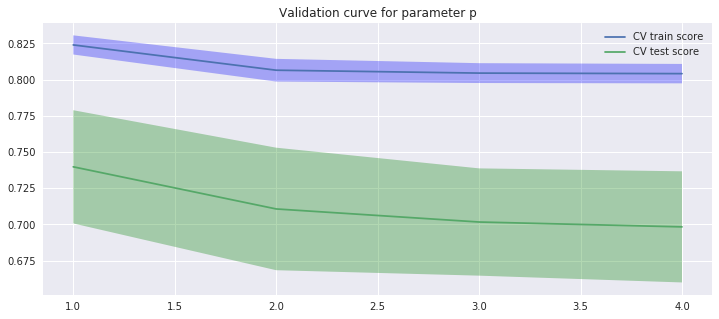

In [15]:
make_validation_curve(knn, X, y, p, 'p')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


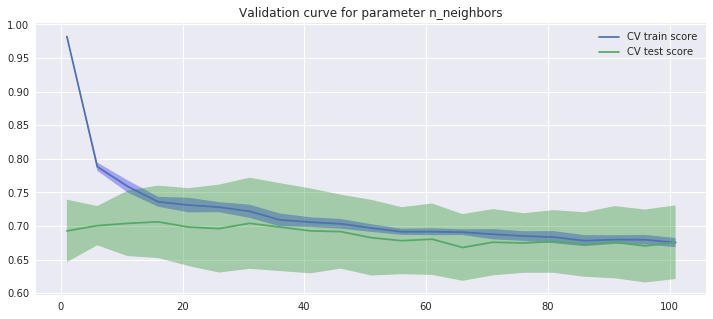

In [16]:
make_validation_curve(knn, X, y, n_neighbors, 'n_neighbors')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


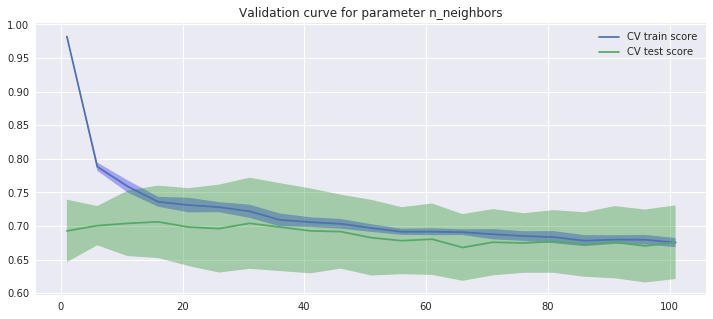

In [17]:
make_validation_curve(knn, X, y, n_neighbors, 'n_neighbors')

In [18]:
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, param_grid={'n_neighbors': n_neighbors,
                                   'metric':metric,
                                   'p':p,
                                   'weights':weights},
                  scoring='accuracy', n_jobs=-1, cv=10, verbose=1) # not f1 because of kaggle rules

In [19]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:   23.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'p': range(1, 5), 'metric': ['minkowski'], 'weights': ['uniform', 'distance'], 'n_neighbors': range(1, 102, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [20]:
print(gs.best_params_)
print('score:', gs.best_score_)

{'p': 1, 'metric': 'minkowski', 'weights': 'distance', 'n_neighbors': 46}
score: 0.741573033708


## Перехерачим фичи

In [21]:
data.drop('PassengerId', inplace=True, axis=1)

In [22]:
# Processing Embarked port
data.Embarked.fillna('S', inplace=True)

In [23]:
data['FamilySize'] = data.SibSp + data.Parch

In [24]:
# Processing Cabin
#data.Cabin.fillna('U', inplace=True)
#data.Cabin = data.Cabin.map(lambda c : c[0])
#cabin_dummies = pd.get_dummies(data.Cabin, prefix='Cabin')
#data = pd.concat([data,cabin_dummies], axis=1)
#data.drop('Cabin', axis=1, inplace=True)

In [25]:
# Process pclass
# encoding into 3 categories:
#pclass_dummies = pd.get_dummies(data['Pclass'], prefix="Pclass")
#data = pd.concat([data,pclass_dummies],axis=1)
#data.drop('Pclass',axis=1,inplace=True)

In [26]:
def isTicketHasPrefix(ticket):
    return not ticket.strip()[0].isdigit()
data.Ticket = data.Ticket.map(isTicketHasPrefix)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           714 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Ticket        891 non-null bool
Fare          891 non-null float64
Cabin         204 non-null object
Embarked      891 non-null object
FamilySize    891 non-null int64
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 77.5+ KB


In [28]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.904602
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


In [29]:
X = data[['Pclass', 'Sex', 'Age', 'FamilySize', 'Ticket', 'Fare']].copy()
X.Sex = X.Sex.map({'male' : 0, 'female' : 1})
X.Age.fillna(value = X['Age'].mean(), inplace=True)
y = data['Survived']

In [30]:
# Для k-means жизненно необходима нормализация
for column in X.columns:
    X[column] = X[column]/X[column].mean()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [32]:
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, param_grid={'n_neighbors': n_neighbors,
                                   'metric':metric,
                                   'p':p,
                                   'weights':weights},
                  scoring='accuracy', n_jobs=-1, cv=10, verbose=1) # not f1 because of kaggle rules

In [33]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1503 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:   39.3s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'p': range(1, 5), 'metric': ['minkowski'], 'weights': ['uniform', 'distance'], 'n_neighbors': range(1, 102, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [34]:
print(gs.best_params_)
print('score:', gs.best_score_)

{'p': 1, 'metric': 'minkowski', 'weights': 'uniform', 'n_neighbors': 26}
score: 0.804173354735


## Готовим сабмит в Kaggle
Для этого скачаем *test.csv* с сайта

In [35]:
real_test_data = pd.read_csv('test.csv')

Повторим часть предобработки

In [36]:
real_test_data['FamilySize'] = real_test_data.SibSp + real_test_data.Parch
real_test_data.Ticket = real_test_data.Ticket.map(isTicketHasPrefix)

In [37]:
X = real_test_data[['Pclass', 'Sex', 'Age', 'FamilySize', 'Ticket', 'Fare']].copy()
X.Sex = X.Sex.map({'male' : 0, 'female' : 1})
X.Age.fillna(value = X.Age.mean(), inplace=True)
X.Fare.fillna(value = X.Fare.mean(), inplace=True) # Почему-то стоимость проезда одного человека неизвестна
#y = data['Survived']
for column in X.columns:
    X[column] = X[column]/X[column].mean()

In [38]:
Y_pred = gs.best_estimator_.predict(X)

In [39]:
submission = pd.DataFrame({
        "PassengerId": real_test_data["PassengerId"],
        "Survived": Y_pred
    })

In [40]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [41]:
submission.to_csv('submission.csv', index=False)

У меня 5955 место, score 0.75120
![Look, it's me on Kaggle](submission_screen.png)